In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.1 MB/s 


In [ ]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
img = cv.imread("/content/drive/MyDrive/face_recognition/dataset/sardor_abdirayimov/5.png")
# opencv BGR channel format and plt reads images as RGB channel format

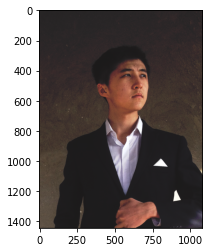

In [ ]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 144ms/step


In [ ]:
results

[{'box': [463, 307, 259, 353],
  'confidence': 0.9999786019325256,
  'keypoints': {'left_eye': (581, 433),
   'right_eye': (684, 432),
   'nose': (669, 493),
   'mouth_left': (611, 577),
   'mouth_right': (683, 573)}}]

In [ ]:
x,y,w,h = results[0]['box']

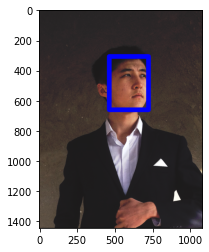

In [ ]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

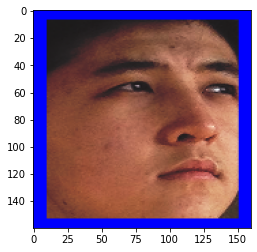

In [ ]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [ ]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

# Automate the preprocessing


In [ ]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [ ]:
faceloading = FACELOADING("/content/drive/MyDrive/face_recognition/dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 47ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 27ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 31ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 35ms/step
Loaded successfully: 10


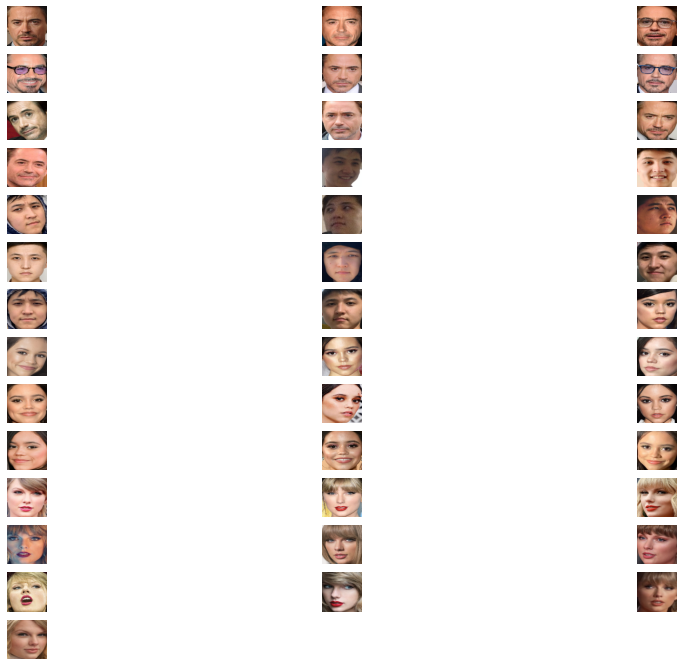

In [ ]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [ ]:
!pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10386 sha256=27b1df02e6e4ef6f06a9e6ab104a612bdba291f77da72f4839b635592c6cdcda
  Stored in directory: /root/.cache/pip/wheels/dc/5f/3a/fa496ade459f1dcb2bdef3ad74cbdff2c90c28d09d6db39859
Successfully built keras-facenet


In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [ ]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 113ms/step


In [ ]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

# SVM model


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '1')

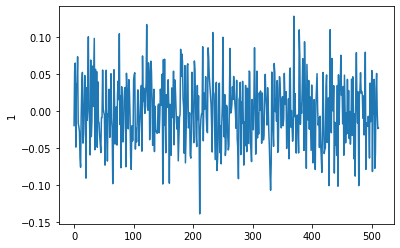

In [ ]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [ ]:
break

SyntaxError: ignored

In [ ]:
Y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

In [ ]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

In [ ]:
accuracy_score(Y_test,ypreds_test)

In [ ]:
t_im = cv.imread("/content/drive/MyDrive/face_recognition/sardor_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

In [ ]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

In [ ]:
encoder.inverse_transform(ypreds)

In [ ]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)